In [2]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import imageio
import random
import seaborn as sns

from sklearn import svm
from skimage import transform, feature, exposure
from scipy import spatial

## Function definitions

In [3]:
def load_data(folder):
    ''' Function to read all whole size images (which will further be split in train 
    and test set).
    Input: 
        folder: path to the folder containing the images.
    Output: 
        imgs: list of images, where each image is represented as numpy array. '''
    
    imgs = []
    labels = {}
    for file in os.listdir(folder):
        if file.endswith('.ppm'):
            imgpath = os.path.join(folder, file)
            imgs.append(np.asarray(imageio.imread(imgpath)))
    return imgs

In [4]:
def load_gt(gt_path):
    ''' Function to read the ground truth for the data, i.e. the bounding boxes 
    describing the location of traffic signs in the images.
    
    Input: 
        gt_path: path to the text file containing ground truth information.
    Output: 
        labels: dictionary containing the image number as key and a list of bounding boxes 
        as value. '''
    
    labels = {k: [] for k in range(900)}
    with open(gt_path, 'r') as gt:
        for line in gt:
            line = line.split(';')
            
            # extract image number
            img_nr = line[0][:-4]
            if img_nr == '00000':
                img_nr = 0
            else: 
                img_nr = int(img_nr.lstrip('0')) # remove leading zeros
            
            # bbox = (leftCol, topRow, rightCol, bottomRow) --> make bounding box quadratic
            leftCol, topRow, rightCol, bottomRow = int(line[1]), int(line[2]), int(line[3]), int(line[4])
            leftCol, topRow, rightCol, bottomRow = make_quadratic(leftCol, topRow, rightCol, bottomRow)
            
            bbox = (leftCol, topRow, rightCol, bottomRow)
            labels[img_nr].append(bbox)
            
    return labels

In [5]:
def make_quadratic(leftCol, topRow, rightCol, bottomRow):
    ''' All rectangluar bounding boxes are converted into quadratic shape by taking the 
    maximal sidelength and enlarge the smaller one equally to both sides. 
    Input:
        leftCol, topRow, rightCol, bottomRow: coordinates of the rectangular bounding box
    Output:
        leftCol, topRow, rightCol, bottomRow: coordinates of the quadratic bounding box '''
    
    diff = (rightCol - leftCol) - (bottomRow - topRow)
            
    if diff > 0:
        bottomRow += math.ceil(abs(diff)/2)
        topRow -= math.floor(abs(diff)/2)
    elif diff < 0:
        rightCol += math.ceil(abs(diff)/2)
        leftCol -= math.floor(abs(diff)/2)
    
    return leftCol, topRow, rightCol, bottomRow

In [6]:
def resize_imgs(imgs, size):
    ''' Function that resizes all given images in place to the same quadratic shape given by the 
    size parameter. 
    Input: 
        imgs: list of images described by numpy arrays.
        size: integer value describing the desired output side length. '''
    
    for i in range(len(imgs)):
        imgs[i] = np.round(transform.resize(imgs[i], (size, size), mode='constant', preserve_range=True,
                                            anti_aliasing=True)).astype(np.uint8)

In [7]:
def get_hog(imgs):
    ''' Function that builds HoG feature descriptors for every of the given image. 
    Input: 
        imgs: list of images, where each image is represented as numpy array.
    Output: 
        hogs: array of hog feature descriptors of dimension [n_images x n_hog_features]. '''
    
    hogs = []
    for image in imgs:
        # Get HoG feature descriptors
        hog_fd = feature.hog(image, orientations=8, pixels_per_cell=(5, 5), cells_per_block=(2, 2),
                             block_norm='L2', multichannel=True)
        hogs.append(hog_fd)
    return np.asarray(hogs)

In [8]:
def sliding_window(image, windowSize, stepSize):
    ''' Function that slides a quadratic window across the image. .  
    Input: 
        image: image where to slide the window accross given as numpy array.
        windowSize: integer value which gives the quadratic side length in pixels of the sliding window.
        stepSize: step size of the sliding window (e.g. 10 pixels).
    Output: 
        windows: list of 3 element tuples (x, y, windowSize, window), where x and y
        are the coordinates of the upper left window edge and window is a numpy array
        of the image path extracted.'''
    
    windows = []
    for y in range(0, image.shape[0]-windowSize, stepSize):
        for x in range(0, image.shape[1]-windowSize, stepSize):
            # yield the current window
            windows.append((x, y, image[y:y + windowSize, x:x + windowSize]))
    return windows

In [9]:
def img_pyramid(image):
    ''' Function to create an image pyramid with scale factors \sqrt(2)^i with i=0,...-5. 
    Input: 
        image: image to create an image pyramid from given as numpy array 
    Output: 
        pyramid: list of numpy arrays describing the scaled versions of the original input
        as well as the original image. '''
    
    p_image = image.copy()
    pyramid = [p_image]

    for i in range(-1,-6,-1):
        scale = math.sqrt(2)**i
        scaled_image = np.round(transform.rescale(p_image, scale , mode='constant', preserve_range=True, 
                                           anti_aliasing=True, multichannel=True)).astype(np.uint8)
        pyramid.append(scaled_image)
        
    return pyramid

In [10]:
# SVM training with one step of hard negative mining
def HNtraining_svm(svm, X_train, y_train, images, neg_imgID, windowSize, stepSize):
    ''' Function that uses hard negative mining to train a svm (in place). 
    Input: 
        svm: object of the sklearn class svm.SVC. 
        X_train: training features of dimension [n_samples x n_features]. 
        y_train: training labels of dimension [n_samples].
        images: list of images, where each image is represented as numpy array. 
        neg_imgID: list of indexes corresponding to the training images without any signs contained. 
        windowSize: integer value which gives the quadratic side length in pixels of sliding window 
            used to obtain more negative samples.
        stepSize: step size of the sliding window (e.g. 10 pixels). '''
        
    lin_svm.fit(X_train, y_train)
    
    # predict on negative training images --> get new hard-negatives
    for imgID in neg_imgID:
        image = images[imgID]
        patches = []
        
        for scaled_img in img_pyramid(image):
            windows = sliding_window(scaled_img, windowSize, stepSize)
            patches.extend([p for (x, y, p) in windows])

        # get HoG features
        hog_patches = get_hog(patches)
        
        # make a prediction
        pred = lin_svm.predict(hog_patches)
        hard_neg = hog_patches[pred==1]

        # add hard negatives to training set
        X_train = np.concatenate((X_train, hard_neg), axis=0)
        y_train = np.concatenate((y_train, [0 for i in range(len(hard_neg))]))
    
    lin_svm.fit(X_train, y_train)

In [11]:
def predict_svm(svm, image, windowSize, stepSize):
    ''' Function to predict bounding boxes of possible traffic signs within one image using a trained 
    support vector machine.
    Input: 
        svm: trained svm object of the sklearn class svm.SVC.
        image: image in which to detect traffic signs given as numpy array.
        windowSize: integer value which gives the quadratic side length in pixels of the sliding window 
            used to search for the object.
        stepSize: step size of the sliding window (e.g. 10 pixels).
    Output: 
        pred_boxes: array of dimension [n_boxes x 4] where the columns indicate leftCol, topRow, 
        rightCol, bottomRow of the predicted bounding box. '''
    
    patches = []
    boxes = [] # store the predicted boxes
    
    for j, scaled_img in enumerate(img_pyramid(image)):
        windows = sliding_window(scaled_img, windowSize, stepSize)
        patches.extend([p for (x, y, p) in windows])
        boxes.extend([(j, x, y, windowSize) for (x, y, p) in windows]) #i stores which scaled image we have
        
    # get HoG features
    hog_patches = get_hog(patches)

    # make a prediction
    pred = lin_svm.predict(hog_patches)
    
    # reconstruct bounding boxes where the classifier predicts a sign to be 
    idx = list(np.where(pred == 1)[0])
    pred_boxes = np.array(boxes)[idx]
    
    # backcompute if the image was scaled 
    for box in pred_boxes:
        i = box[0]
        if i > 0:
            scale = math.sqrt(2)**(-i)
            box[1] = math.floor(box[1]/scale)
            box[2] = math.floor(box[2]/scale)
            box[3] = math.floor(box[3]/scale)
        
        # rearange the pred bounding boxes in the format: leftCol, topRow, rightCol, bottomRow
        box[0] = box[1]
        box[1] = box[2]
        box[2] = box[0] + box[3]
        box[3] = box[1] + box[3]
    
    return pred_boxes

In [12]:
def intersection_over_union(boxA, boxB):
    ''' Function that calculates the intersection over union between two given 
    bouding boxes: 
    Input: 
        boxA: list/tuple/array containing 4 elements describing leftCol, topRow, 
        rightCol, bottomRow of the box.
        boxB: same as boxA.
    Output:
        iou: float value describing the intersection over union between boxA and boxB. '''
    
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = (xB - xA) * (yB - yA)
    # catch the case of no intersection at all (interArea < 0)
    if (xB - xA) <= 0 or (yB - yA) <= 0:
        interArea = 0
    
    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of (prediction + ground-truth
    # areas - the interesection area)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

In [13]:
def performance_on_image(gtBoxes, predBoxes):
    ''' Measure performance by means of the intersection over union 
    values between all ground truth bounding boxes and the best (most overlapping) 
    predicted bouding box. When IOU >= 0.5, the sign is counted as detected, otherwise 
    it is regarded as not detected. 
    Input:
        gtBoxes: list/array of ground truth bouding boxes.
        predBoxes: list/array of predicted bouding boxes.
    Output: 
        det_rate: fraction of traffic signs detected in the image. 
        false_pos: fraction of false positives i.e. predicted bounding boxes that have zero 
        overlap with any of the ground truth boxes. '''
    
    gtBoxes = np.asarray(gtBoxes)
    # catch special cases
    if gtBoxes.shape[0] == 0 and predBoxes.shape[0] == 0:
        det_rate, false_pos = 1.0, 0.0
        return det_rate, false_pos
    elif gtBoxes.shape[0] > 0 and predBoxes.shape[0] == 0:
        det_rate, false_pos = 1.0, 0.0
        return det_rate, false_pos
    elif gtBoxes.shape[0] == 0 and predBoxes.shape[0] > 0:
        det_rate, false_pos = 1.0, 1.0
        return det_rate, false_pos

    # compute intersection over union for all true signs with all predicted boxes
    dist = spatial.distance.cdist(gtBoxes, predBoxes, metric=intersection_over_union)

    # catch best overlapping predicted bounding box for every ground truth bounding box.
    best_iou = np.sort(dist, axis = 1)[:, -1] # select best overlapping bbox each (hightest iou)

    best_iou[best_iou >= 0.5] = 1 
    best_iou[best_iou < 0.5] = 0
    recall = np.sum(best_iou)/gtBoxes.shape[0]                          # rate of detected ground truth signs
    false_pos = len(np.where(~dist.any(axis=0))[0])/predBoxes.shape[0]  # rate of false positives
    
    return det_rate, false_pos

In [14]:
def evaluate_performance(svm, images, gtBoxes, indices, windowSize, stepSize):
    ''' Function to evaluate the classifier's performance on a given set of 
    images. 
    Input:
        svm: trained svm object of the sklearn class svm.SVC.
        gtBoxes: dictionary containing the image number as key and a list of bounding boxes 
        as value (obtained from the function load_gt).
        indexes: list of indexes corresponding to the images on which a prediction should be made.
        windowSize: integer value which gives the quadratic side length in pixels of the sliding window 
            used to search for the object.
        stepSize: step size of the sliding window (e.g. 10 pixels).
    Output: 
        avg_acc: average prediction accuracy measured by means of the fraction of detected 
        ground truth signs over all given images. 
        avg_fp: average false positive rate measured by means of the fraction of detected
        false positive signs over all given images. '''
    
    avg_acc = 0.0
    avg_fp = 0.0
    
    for idx in indices:
        image = images[idx]
        gt = gtBoxes[idx]
        pred_boxes = predict_svm(svm, image, windowSize, stepSize)
        det_rate, false_pos = performance_on_image(gt, pred_boxes)
        avg_acc += det_rate
        avg_fp += false_pos
    
    avg_acc = avg_acc/len(indices)
    avg_fp = avg_fp/len(indices)
    
    return avg_acc, avg_fp

In [15]:
def nice_plot(fig_size, n_rows, n_cols, images, title=None, path=None):
    fig, axs = plt.subplots(figsize=fig_size, nrows=n_rows, ncols=n_cols)
    ind = 0
    for i in range(n_rows):
        for j in range(n_cols):
            axs[i,j].imshow(images[ind])
            if title:
                axs[i,j].set_title(title, fontsize=26)
            axs[i,j].axis('off')
            ind += 1
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.02, hspace=0)
    if path:
        plt.savefig(path)
    else:
        plt.show()

## Main Code
#### Training and Prediction

In [16]:
# Parameter setting  
train_set_size = 600      # Size of the training set (total set consists of 900 images)
nr_negatives = 5000       # Nr of negative sample patches to start training the SVM with
wsize = 30                # Sidelength in pixels for the quadratic sliding window
stepSize_train = 10       # Stepsize in pixels for the sliding window during training
stepSize_detect = 5       # Stepsize in pixels for the sliding window during detection

In [17]:
# Load whole size images and ground truth data
images = load_data('../data/FullIJCNN2013/')
bboxes = load_gt('../data/FullIJCNN2013/gt.txt')

In [18]:
# Split into train and test set using index sets
train_idx = random.sample([k for k in range(900)], train_set_size)
test_idx = [k for k in range(900) if k not in train_idx]

In [19]:
# Prepare positive patches
pos_patches = []
for idx in train_idx:
    image = images[idx]
    bbox = bboxes[idx]
    for box in bbox:
        patch = image[box[1]:box[3], box[0]:box[2]]
        pos_patches.append(patch)

resize_imgs(pos_patches, size=wsize) # resize patches

In [20]:
# Prepare negative patches
neg_imgID = [k for k in train_idx if len(bboxes[k]) == 0]  # images without any traffic signs 
neg_patches = []
for imgID in neg_imgID:
    image = images[imgID]
    windows = sliding_window(image, stepSize=wsize, windowSize=wsize)
    patches = [p for (x,y,p) in windows]
    neg_patches.extend(patches)
     
neg_patches = random.sample(neg_patches, nr_negatives) # choose nr_negatives negative patches

In [21]:
# Create HoG features
hog_pos_patches = get_hog(pos_patches)
hog_neg_patches = get_hog(neg_patches)

In [22]:
# Construct training set from positive and negative patches
X_train = np.concatenate((hog_pos_patches, hog_neg_patches), axis = 0)
pos_labels = [1 for i in range(len(hog_pos_patches))]
neg_labels = [0 for i in range(len(hog_neg_patches))]
y_train = np.asarray(pos_labels + neg_labels)

In [109]:
# Generate Support Vector Machine 
lin_svm = svm.SVC(kernel='linear') 

In [74]:
# Option 1: Simple Training of SVM
lin_svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [110]:
# Option 2: Train SVM using hard negative mining
HNtraining_svm(lin_svm, X_train, y_train, images, neg_imgID, windowSize=wsize, stepSize=stepSize_train)

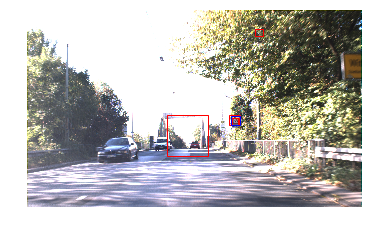

Detection performance on image: 1.0. 
False positive rate: 0.4


In [113]:
# Predict bounding boxes and visualize them for one image. Therefore specialize pred_idx:
pred_idx = 20
predicted_boxes = predict_svm(lin_svm, images[pred_idx], windowSize=wsize, stepSize=stepSize_detect)

# Create figure and axes
fig,ax = plt.subplots(1)
# Display the image
ax.imshow(images[pred_idx])
ax.axis('off')
# Draw all predicted bouding boxes
for box in predicted_boxes:
    ws = box[2] - box[0]
    rect = pat.Rectangle((box[0], box[1]), ws, ws, linewidth=1,edgecolor='r', facecolor='none')
    ax.add_patch(rect)
# Draw ground truth bounding boxes
for box in bboxes[pred_idx]:
    ws = box[2] - box[0]
    rect = pat.Rectangle((box[0], box[1]), ws, ws, linewidth=1,edgecolor='b', facecolor='none')
    ax.add_patch(rect)
plt.savefig('./ex_pred_boxes.png')    
plt.show()

# Print performance on that image
perf_img, fp = performance_on_image(bboxes[pred_idx], predicted_boxes)
print('Detection performance on image: %s. \nFalse positive rate: %s' %(perf_img, fp))

In [112]:
# Compute detection accuracy for a set of images. Therefore specialize image_set, which is a set of indices:
image_set =  test_idx[150:180]  # train_idx[330:360]
det_perf, fp_rate = evaluate_performance(lin_svm, images, bboxes, image_set, windowSize=wsize, stepSize=stepSize_detect)
print('Detection performance on the given set of images: %s. \nFalse positive rate on the given set of images: %s' %(det_perf, fp_rate))

Detection performance on the given set of images: 0.966666666667. 
 False positive rate on the given set of images: 0.4899013949013949


#### Visualization

In [29]:
# Visualization of some example images
rimg = random.sample(images,12)
nice_plot(fig_size=(20,17), n_rows=4, n_cols=3, images=rimg, title=None, path='./ex_imgs.png')

In [30]:
# Visualization of some positive and negative patches
patches_to_plot = pos_patches[50:60] + neg_patches[21:31]
nice_plot(fig_size=(50,40), n_rows=4, n_cols=5, images=patches_to_plot, title=None, path='./pos_neg_patches.png')

In [25]:
# Visualize some data and corresponding HoG image
patch_list_n = [neg_patches[25], neg_patches[45], neg_patches[28]]
patch_list_p = [pos_patches[54], pos_patches[59], pos_patches[57]]

for nr, patch_list in enumerate([patch_list_n, patch_list_p]):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 13), sharex=True, sharey=True)

    for i in range(3):
        fd, hog_image = feature.hog(patch_list[i], orientations=8, pixels_per_cell=(5, 5), cells_per_block=(2, 2),
                                 block_norm='L2', multichannel=True, visualize=True)


        ax[i,0].axis('off')
        ax[i,0].imshow(patch_list[i])

        # Rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        ax[i,1].axis('off')
        ax[i,1].imshow(hog_image_rescaled, cmap=plt.cm.gray)
    plt.savefig('./hog' + str(nr) + '.png')

In [28]:
# Visualization of Detection Performance for a set of test images depending on the step size of 
# the sliding window used for detection.
sns.set_style("whitegrid")
plt.figure()
# plt.scatter(x=[3,5,10,15,30], y=[0.9, 0.792, 0.575, 0.234, 0.150], c='red', alpha=0.7) jaccard >= 0.6
plt.scatter(x=[3,5,10,15,30], y=[0.958, 0.917, 0.683, 0.625, 0.516], c='red', alpha=0.7) # jaccard >= 0.5
plt.xlabel('Step size')
plt.ylabel('Detection Performance')
plt.ylim(0,1)
plt.xlim(0,35)
plt.savefig('./step_performance_jaccthres0-5')